<a href="https://colab.research.google.com/github/GitDonry/mat1/blob/main/Matlab_trans2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dont forget to coonect to cloud drive!!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set path

In [2]:
import os
os.chdir('/content/drive/MyDrive/Matlab_trans/Vicon_analysis-main/Vicon_analysis-main/data')

Check data files

In [3]:
import glob

glob.glob('*')


['3-Left.xlsx',
 '12-Left hindlimb.tif',
 '11-1-gait.xlsx',
 '12-Right.xlsx',
 '3-Right.xlsx',
 '2-Right hindlimb.tif',
 '2.csv',
 '10-Left hindlimb.tif',
 '12.csv',
 '3-Right hindlimb.tif',
 '11-1-Right.xlsx',
 '2-gait.xlsx',
 '12-gait.xlsx',
 '4-Right hindlimb.tif',
 '12-Right hindlimb.tif',
 '12-Left.xlsx',
 '4-Left.xlsx',
 '10-Right hindlimb.tif',
 '14-Right.xlsx',
 '4-gait.xlsx',
 '4-Left hindlimb.tif',
 '11-1-Left.xlsx',
 '3-Left hindlimb.tif',
 '3.csv',
 '11-1-Right hindlimb.tif',
 '11-1.csv',
 '10-Left.xlsx',
 '2-Right.xlsx',
 '14-Left hindlimb.tif',
 '3-gait.xlsx',
 '10.csv',
 '11-1-Left hindlimb.tif',
 '2-Left hindlimb.tif',
 '14-gait.xlsx',
 '10-gait.xlsx',
 '14-Left.xlsx',
 '2-Left.xlsx',
 '14-Right hindlimb.tif',
 '14.csv',
 '4-Right.xlsx',
 '9-Right hindlimb.tif',
 '9-Right.xlsx',
 '9-Left hindlimb.tif',
 '9-gait.xlsx',
 '7-Left hindlimb.tif',
 '9.csv',
 '7-Right.xlsx',
 'ParameterList.xlsx',
 '4.csv',
 '7-gait.xlsx',
 '7.csv',
 '7-Left.xlsx',
 '9-Left.xlsx',
 '7-Right hi

dataCalculate_Bo function

In [59]:
import os
import numpy as np
import pandas as pd

def data_calculate_bo(input_file, output_dir=None, speed=0.0, framerate=100):

  # === 1) Read marker names ===
    marker_row = pd.read_csv(
    input_file,
    skiprows=2,
    nrows=1,
    header=None
    )

# Drop any columns that are entirely NaN (e.g. trailing blanks)
    marker_row = marker_row.dropna(axis=1, how='all')

# Now extract every 3rd column from col#2 onwards
    marker_names = marker_row.iloc[0, 2::3].tolist()
# And finally filter out any leftover NaNs just in case
    marker_names = [m for m in marker_names if pd.notna(m)]


    # === 2) Read numeric data ===
    raw_df = pd.read_csv(input_file, skiprows=5, header=None, engine='python')
    num_df = raw_df.apply(pd.to_numeric, errors='coerce').dropna(axis=0)
    num_array = num_df.values

    # If no data, skip
    if num_array.shape[0] == 0:
        print(f"⚠️  No valid data in {input_file}, skipping.")
        return

    # === 3) Frame & coordinates ===
    frame_first = num_array[0, 0]
    nframe = num_array[:, 0] - frame_first + 1
    data = num_array[:, 2:]

    # === 4) X-direction compensation ===
    t = np.arange(1, data.shape[0] + 1)
    data[:, 0::3] += (speed / framerate) * t[:, np.newaxis]

    # === 5) Extract marker data by name ===
    marker_list = {
        'R_Crest': 'SETUP 1:R_Crest',
        'R_Hip': 'SETUP 1:R_Hip',
        'R_Knee': 'SETUP 1:R_Knee',
        'R_Ankle': 'SETUP 1:R_Ankle',
        'R_Foot': 'SETUP 1:R_Foot',
        'R_Shoulder': 'SETUP 1:R_Shoulder',
        'R_Elbow': 'SETUP 1:R_Elbow',
        'R_Paw': 'SETUP 1:R_Paw',
        'L_Crest': 'SETUP 1:L_Crest',
        'L_Hip': 'SETUP 1:L_Hip',
        'L_Knee': 'SETUP 1:L_Knee',
        'L_Ankle': 'SETUP 1:L_Ankle',
        'L_Foot': 'SETUP 1:L_Foot',
        'L_Shoulder': 'SETUP 1:L_Shoulder',
        'L_Elbow': 'SETUP 1:L_Elbow',
        'L_Paw': 'SETUP 1:L_Paw'
    }

    marker_data = {}
    for key, name in marker_list.items():
        if name in marker_names:
            idx = marker_names.index(name)
            marker_data[key] = data[:, 3*idx:3*idx+3]
        else:
            print(f"⚠️  {name} missing, skipping.")

    # === Compute vectors ===
    vectors = compute_vectors(marker_data)

    # === Compute angles and velocities ===
    angles = compute_angles(vectors)
    velocities = {k: compute_velocity(v) for k, v in angles.items()}

    # === Gait event detection ===
    gait_events = {
        'R_Hind': gait_define_height(marker_data['R_Foot'], 5),
        'R_Fore': gait_define_height(marker_data['R_Paw'], 4),
        'L_Hind': gait_define_height(marker_data['L_Foot'], 5),
        'L_Fore': gait_define_height(marker_data['L_Paw'], 4),
    }

    # === Extract features ===
    features_data = []
    for joint, angle_data in angles.items():
        swing_start = gait_events['R_Hind'][0] if joint.endswith('_R') else gait_events['L_Hind'][0]
        features = compute_cycle_features(angle_data, swing_start, framerate)
        feature_names = [
            f"{joint}_mean", f"{joint}_range", f"{joint}_min", f"{joint}_max",
            f"{joint}_vel_mean", f"{joint}_vel_range", f"{joint}_vel_min", f"{joint}_vel_max"
        ]
        df_features = pd.DataFrame(features, columns=feature_names)
        features_data.append(df_features)

    # === Compute correlations ===
    correlation_pairs = [
        ('hip_R', 'knee_R'), ('knee_R', 'ankle_R'), ('hip_R', 'ankle_R'),
        ('crest_R', 'thigh_R'), ('thigh_R', 'shank_R'), ('shank_R', 'foot_R'),
        ('hip_L', 'knee_L'), ('knee_L', 'ankle_L'), ('hip_L', 'ankle_L'),
        ('crest_L', 'thigh_L'), ('thigh_L', 'shank_L'), ('shank_L', 'foot_L'),
        ('hip_R', 'hip_L'), ('knee_R', 'knee_L'), ('ankle_R', 'ankle_L'),
        ('crest_R', 'crest_L'), ('thigh_R', 'thigh_L'), ('shank_R', 'shank_L'), ('foot_R', 'foot_L')
    ]

    correlations_data = []
    for pair in correlation_pairs:
        if pair[0] not in angles or pair[1] not in angles:
            print(f"Skipping correlation {pair}: missing data.")
            continue
        swing_start = gait_events['R_Hind'][0] if pair[0].endswith('_R') else gait_events['L_Hind'][0]
        corrs = compute_corrcoef(angles[pair[0]], angles[pair[1]], swing_start)
        df_corr = pd.DataFrame({f"{pair[0]}_vs_{pair[1]}_corr": corrs})
        correlations_data.append(df_corr)

       # === 2) 合并 DataFrame 并打印形状/列名，方便检查 ===
    features_df = pd.concat(features_data, axis=1) if features_data else pd.DataFrame()
    correlations_df = pd.concat(correlations_data, axis=1) if correlations_data else pd.DataFrame()

    print("Features shape:", features_df.shape)
    print("Correlations shape:", correlations_df.shape)

    # === 8) 决定写到哪 ===
    base = os.path.splitext(os.path.basename(input_file))[0]
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f"{base}_results.xlsx")
    else:
        out_path = f"{base}_results.xlsx"

    # === 9) 写 Excel ===
    print(f"📌 Preparing to write file for: {input_file}")
    try:
     with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            features_df.to_excel(writer, sheet_name='Features', index=False)
            correlations_df.to_excel(writer, sheet_name='Correlations', index=False)
     print(f"✅ Results written to: {out_path}")
    except Exception as e:
     print(f"❌ Failed to write {out_path}: {e}")

    return out_path



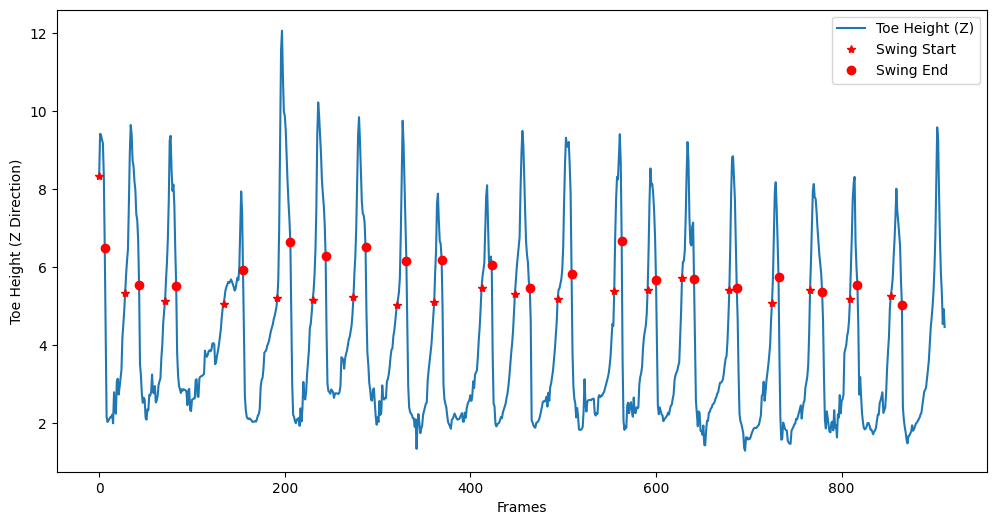

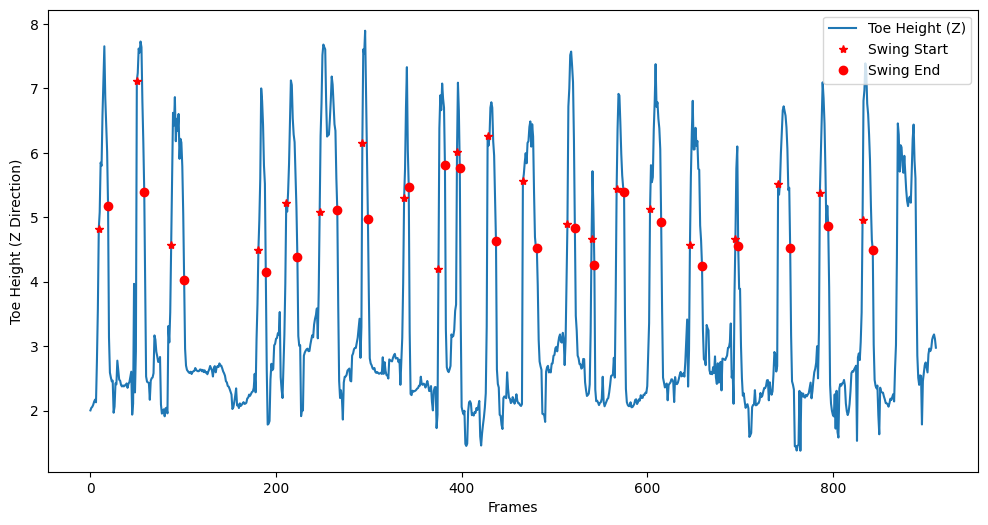

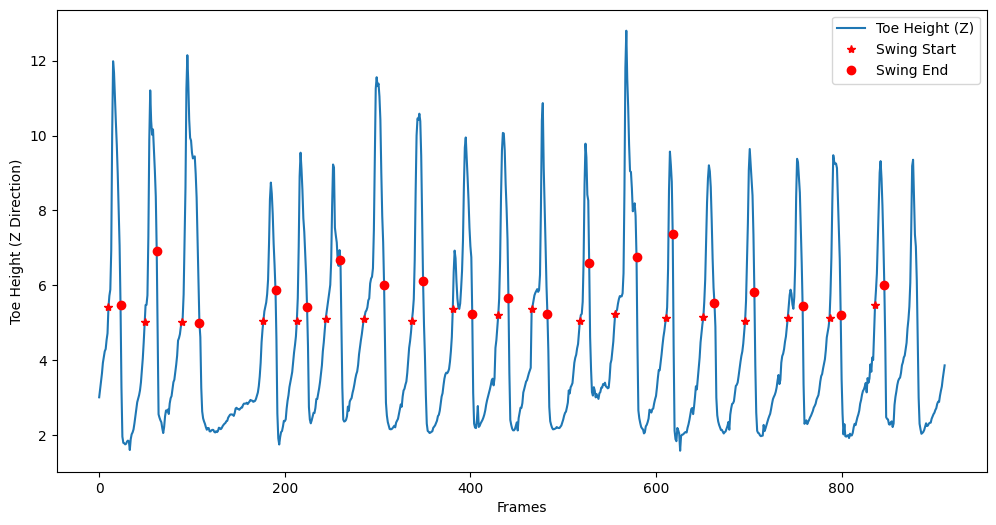

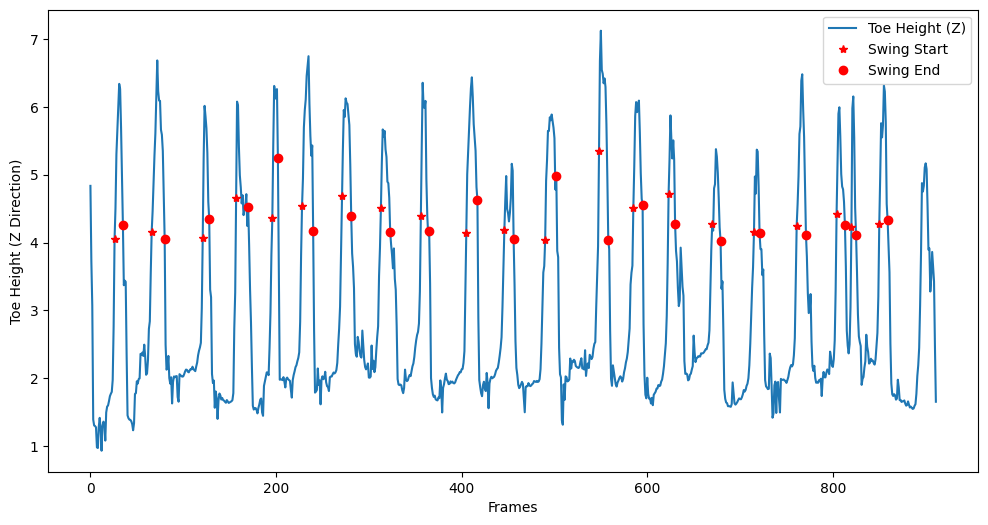

Features shape: (19, 224)
Correlations shape: (19, 19)
📌 Preparing to write file for: 2.csv
✅ Results written to: 2_results.xlsx


'2_results.xlsx'

In [52]:
data_calculate_bo('2.csv', None, speed=0.0, framerate=100)

In [50]:
def compute_cycle_features(angle, swing_start, framerate):
    """
    Compute mean, range, min, max, velocity stats for each gait cycle.
    """
    results = []
    for i in range(len(swing_start) - 1):
        segment = angle[swing_start[i]:swing_start[i+1]]
        velocity = np.diff(segment) * framerate
        velocity = np.append(velocity, velocity[-1])
        features = [
            np.mean(segment), np.ptp(segment), np.min(segment), np.max(segment),
            np.mean(velocity), np.ptp(velocity), np.min(velocity), np.max(velocity)
        ]
        results.append(features)
    return np.array(results)

def compute_corrcoef(a1, a2, swing_start):
    """
    Compute correlation coefficient between two angles for each gait cycle.
    """
    corrs = []
    for i in range(len(swing_start) - 1):
        seg1 = a1[swing_start[i]:swing_start[i+1]]
        seg2 = a2[swing_start[i]:swing_start[i+1]]
        if len(seg1) < 2 or len(seg2) < 2:
            corrs.append(np.nan)
            continue
        corr_matrix = np.corrcoef(seg1, seg2)
        corrs.append(corr_matrix[0,1])
    return np.array(corrs)


In [42]:
def compute_vectors(marker_data):
    """
    Compute key vectors for both sides.
    """
    vectors = {}
    vectors['hip_il_R'] = marker_data['R_Crest'] - marker_data['R_Hip']
    vectors['hip_knee_R'] = marker_data['R_Knee'] - marker_data['R_Hip']
    vectors['ankle_knee_R'] = marker_data['R_Knee'] - marker_data['R_Ankle']
    vectors['ankle_toe_R'] = marker_data['R_Foot'] - marker_data['R_Ankle']
    vectors['il_toe_R'] = marker_data['R_Foot'] - marker_data['R_Crest']
    vectors['shoulder_elbow_R'] = marker_data['R_Shoulder'] - marker_data['R_Elbow']
    vectors['elbow_paw_R'] = marker_data['R_Paw'] - marker_data['R_Elbow']
    vectors['shoulder_paw_R'] = marker_data['R_Paw'] - marker_data['R_Shoulder']

    vectors['hip_il_L'] = marker_data['L_Crest'] - marker_data['L_Hip']
    vectors['hip_knee_L'] = marker_data['L_Knee'] - marker_data['L_Hip']
    vectors['ankle_knee_L'] = marker_data['L_Knee'] - marker_data['L_Ankle']
    vectors['ankle_toe_L'] = marker_data['L_Foot'] - marker_data['L_Ankle']
    vectors['il_toe_L'] = marker_data['L_Foot'] - marker_data['L_Crest']
    vectors['shoulder_elbow_L'] = marker_data['L_Shoulder'] - marker_data['L_Elbow']
    vectors['elbow_paw_L'] = marker_data['L_Paw'] - marker_data['L_Elbow']
    vectors['shoulder_paw_L'] = marker_data['L_Paw'] - marker_data['L_Shoulder']

    vectors['xdirection'] = np.zeros_like(vectors['hip_il_R'])
    vectors['xdirection'][:, 0] = 1
    vectors['zdirection'] = np.zeros_like(vectors['hip_il_R'])
    vectors['zdirection'][:, 2] = 1

    return vectors



In [46]:
def degree_trans(vector1, vector2):
    """
    Compute angle in degrees between two 3D vectors for each frame.
    """
    theta_degrees = []
    for u, v in zip(vector1, vector2):
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        if norm_u == 0 or norm_v == 0:
            theta_degrees.append(np.nan)
            continue
        cos_theta = np.dot(u, v) / (norm_u * norm_v)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        theta = np.degrees(np.arccos(cos_theta))
        theta_degrees.append(theta)
    return np.array(theta_degrees)

def compute_angles(vectors):
    """
    Compute all joint angles.
    """
    angles = {}
    angles['hip_R'] = degree_trans(vectors['hip_il_R'], vectors['hip_knee_R'])
    angles['knee_R'] = degree_trans(vectors['hip_knee_R'], vectors['ankle_knee_R'])
    angles['ankle_R'] = degree_trans(vectors['ankle_knee_R'], vectors['ankle_toe_R'])
    angles['elbow_R'] = degree_trans(vectors['shoulder_elbow_R'], vectors['elbow_paw_R'])
    angles['limb_R'] = degree_trans(vectors['xdirection'], vectors['il_toe_R'])
    angles['crest_R'] = degree_trans(vectors['zdirection'], vectors['hip_il_R'])
    angles['thigh_R'] = degree_trans(vectors['xdirection'], vectors['hip_knee_R'])
    angles['shank_R'] = degree_trans(vectors['xdirection'], vectors['ankle_knee_R'])
    angles['foot_R'] = degree_trans(vectors['xdirection'], vectors['ankle_toe_R'])
    angles['arm_R'] = degree_trans(vectors['xdirection'], vectors['shoulder_elbow_R'])
    angles['forearm_R'] = degree_trans(vectors['xdirection'], vectors['elbow_paw_R'])
    angles['forelimb_R'] = degree_trans(vectors['xdirection'], vectors['shoulder_paw_R'])
    angles['armVert_R'] = degree_trans(vectors['zdirection'], vectors['shoulder_elbow_R'])
    angles['forearmVert_R'] = degree_trans(vectors['zdirection'], vectors['elbow_paw_R'])

    angles['hip_L'] = degree_trans(vectors['hip_il_L'], vectors['hip_knee_L'])
    angles['knee_L'] = degree_trans(vectors['hip_knee_L'], vectors['ankle_knee_L'])
    angles['ankle_L'] = degree_trans(vectors['ankle_knee_L'], vectors['ankle_toe_L'])
    angles['elbow_L'] = degree_trans(vectors['shoulder_elbow_L'], vectors['elbow_paw_L'])
    angles['limb_L'] = degree_trans(vectors['xdirection'], vectors['il_toe_L'])
    angles['crest_L'] = degree_trans(vectors['zdirection'], vectors['hip_il_L'])
    angles['thigh_L'] = degree_trans(vectors['xdirection'], vectors['hip_knee_L'])
    angles['shank_L'] = degree_trans(vectors['xdirection'], vectors['ankle_knee_L'])
    angles['foot_L'] = degree_trans(vectors['xdirection'], vectors['ankle_toe_L'])
    angles['arm_L'] = degree_trans(vectors['xdirection'], vectors['shoulder_elbow_L'])
    angles['forearm_L'] = degree_trans(vectors['xdirection'], vectors['elbow_paw_L'])
    angles['forelimb_L'] = degree_trans(vectors['xdirection'], vectors['shoulder_paw_L'])
    angles['armVert_L'] = degree_trans(vectors['zdirection'], vectors['shoulder_elbow_L'])
    angles['forearmVert_L'] = degree_trans(vectors['zdirection'], vectors['elbow_paw_L'])

    return angles

def compute_velocity(angle_array):
    """
    Compute angle velocity (first derivative).
    """
    velocity = np.diff(angle_array)
    velocity = np.append(velocity, velocity[-1])
    return velocity



**combineExcel**

In [7]:
import pandas as pd

def combine_excel_means(input_file, output_file=None):
    """
    Combine means of each sheet (except the first sheet) in an Excel file.

    Parameters:
    input_file : str
        The input Excel file name (with path if not in current directory)
    output_file : str, optional
        The output Excel file name. If None, default to 'combine-' + input_file
    """
    if output_file is None:
        output_file = f'combine-{input_file}'

    # Read the Excel file
    xls = pd.ExcelFile(input_file)
    sheet_names = xls.sheet_names

    # Initialize an empty DataFrame to store combined data
    combined_df = pd.DataFrame()

    # Process each sheet except the first one
    for sheet_name in sheet_names[1:]:
        df = pd.read_excel(xls, sheet_name=sheet_name)

        # Compute mean across rows (numeric columns only)
        mean_values = df.mean(axis=0, numeric_only=True)

        # Convert mean values to DataFrame
        mean_df = pd.DataFrame([mean_values])

        # Add sheet name as a column
        mean_df['SheetName'] = sheet_name

        # Append to combined DataFrame
        combined_df = pd.concat([combined_df, mean_df], ignore_index=True)

    # Write combined result to Excel
    combined_df.to_excel(output_file, index=False)
    print(f'Combined data written to {output_file}')


correlation_cal2

In [8]:
import numpy as np
from scipy.signal import correlate

def correlation_cal2(current_data1, current_data2, swing_start1, swing_start2):
    """
    Calculate correlation between two signals for each gait cycle.

    Parameters:
    current_data1 : array-like
        The first signal data (1D array)
    current_data2 : array-like
        The second signal data (1D array)
    swing_start1 : array-like
        Start indices for cycles of first signal
    swing_start2 : array-like
        Start indices for cycles of second signal

    Returns:
    R : list
        Correlation coefficients at lag=0 for each cycle
    LAG : list
        Lag value at which maximum correlation occurred for each cycle
    """
    R = []
    LAG = []

    num_cycles = min(len(swing_start1), len(swing_start2)) - 1
    for j in range(num_cycles):
        step1 = current_data1[swing_start1[j]:swing_start1[j+1]]
        step2 = current_data2[swing_start2[j]:swing_start2[j+1]]

        # Compute cross-correlation
        r_full = correlate(step1 - np.mean(step1), step2 - np.mean(step2), mode='full')
        r_full = r_full / (np.std(step1) * np.std(step2) * len(step1))

        lags = np.arange(-len(step1) + 1, len(step2))

        # Correlation at lag 0
        zero_idx = np.where(lags == 0)[0][0]
        R.append(r_full[zero_idx])

        # Lag at max correlation
        max_idx = np.argmax(r_full)
        LAG.append(lags[max_idx])

    return R, LAG


correlationcoef_cal

In [9]:
import numpy as np

def correlationcoef_cal(angle1, angle2, swing_start):
    """
    Calculate correlation coefficient between two angle signals for each gait cycle.

    Parameters:
    angle1 : array-like
        The first angle data (1D array)
    angle2 : array-like
        The second angle data (1D array)
    swing_start : array-like
        Indices marking the start of each gait cycle

    Returns:
    CC : list
        Correlation coefficient for each cycle
    """
    CC = []
    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        current_angle1 = angle1[swing_start[j]:swing_start[j+1]]
        current_angle2 = angle2[swing_start[j]:swing_start[j+1]]

        # Compute correlation coefficient
        if len(current_angle1) != len(current_angle2):
            # Make sure lengths match (can pad or trim if needed)
            min_len = min(len(current_angle1), len(current_angle2))
            current_angle1 = current_angle1[:min_len]
            current_angle2 = current_angle2[:min_len]

        corr_matrix = np.corrcoef(current_angle1, current_angle2)
        CC.append(corr_matrix[0, 1])

    return CC


degree_cal2

In [10]:
import numpy as np

def degree_cal2(current_data, swing_start, stance_start, framerate=None):
    """
    Calculate mean, range, min, max joint angle for swing, stance, and gait cycle.

    Parameters:
    current_data : array-like
        The joint angle data (1D or 2D array)
    swing_start : array-like
        Indices marking start of swing phase
    stance_start : array-like
        Indices marking start of stance phase
    framerate : not used (included for compatibility)

    Returns:
    angle_data_swing : ndarray
        Metrics for swing phase [mean, range, min, max]
    angle_data_stance : ndarray
        Metrics for stance phase [mean, range, min, max]
    angle_data_gait : ndarray
        Metrics for gait cycle [mean, range, min, max]
    """
    step_swing_mean = []
    step_swing_range = []
    step_swing_min = []
    step_swing_max = []

    step_stance_mean = []
    step_stance_range = []
    step_stance_min = []
    step_stance_max = []

    step_mean = []
    step_range = []
    step_min = []
    step_max = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        # Swing phase
        step_swing = current_data[swing_start[j]:stance_start[j], :]
        step_swing_mean.append(np.mean(step_swing, axis=0))
        step_swing_range.append(np.ptp(step_swing, axis=0))  # ptp = max - min
        step_swing_min.append(np.min(step_swing, axis=0))
        step_swing_max.append(np.max(step_swing, axis=0))

        # Stance phase
        step_stance = current_data[stance_start[j]:swing_start[j+1], :]
        step_stance_mean.append(np.mean(step_stance, axis=0))
        step_stance_range.append(np.ptp(step_stance, axis=0))
        step_stance_min.append(np.min(step_stance, axis=0))
        step_stance_max.append(np.max(step_stance, axis=0))

        # Full gait cycle
        step = current_data[swing_start[j]:swing_start[j+1], :]
        step_mean.append(np.mean(step, axis=0))
        step_range.append(np.ptp(step, axis=0))
        step_min.append(np.min(step, axis=0))
        step_max.append(np.max(step, axis=0))

    # Combine results
    angle_data_swing = np.hstack([
        np.array(step_swing_mean),
        np.array(step_swing_range),
        np.array(step_swing_min),
        np.array(step_swing_max)
    ])

    angle_data_stance = np.hstack([
        np.array(step_stance_mean),
        np.array(step_stance_range),
        np.array(step_stance_min),
        np.array(step_stance_max)
    ])

    angle_data_gait = np.hstack([
        np.array(step_mean),
        np.array(step_range),
        np.array(step_min),
        np.array(step_max)
    ])

    return angle_data_swing, angle_data_stance, angle_data_gait


degree_calculate

In [11]:
import numpy as np

def degree_calculate(current_data, swing_start, framerate):
    """
    Calculate mean, range, min, max of joint angle and velocity for each gait cycle.

    Parameters:
    current_data : array-like
        The joint angle data (1D or 2D array)
    swing_start : array-like
        Indices marking start of swing phase
    framerate : float
        Frame rate for calculating velocity

    Returns:
    angle_data : ndarray
        Metrics for angle [mean, range, min, max] per cycle
    angle_data_velocity : ndarray
        Metrics for angle velocity [mean, range, min, max] per cycle
    """
    current_data = np.array(current_data)
    current_data_velocity = np.diff(current_data, axis=0) * framerate

    step_mean = []
    step_range = []
    step_min = []
    step_m_


degree_calculate_stance

In [12]:
import numpy as np

def degree_calculate_stance(current_data, swing_start, swing_end):
    """
    Calculate mean, range, min, max of joint angle for stance phase in each gait cycle.

    Parameters:
    current_data : array-like
        The joint angle data (1D or 2D array)
    swing_start : array-like
        Indices marking start of swing phase
    swing_end : array-like
        Indices marking end of swing phase

    Returns:
    angle_data : ndarray
        Metrics for stance phase [mean, range, min, max] per cycle
    """
    current_data = np.array(current_data)

    step_mean = []
    step_range = []
    step_min = []
    step_max = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        step = current_data[swing_end[j]:swing_start[j+1], :]
        step_mean.append(np.mean(step, axis=0))
        step_range.append(np.ptp(step, axis=0))
        step_min.append(np.min(step, axis=0))
        step_max.append(np.max(step, axis=0))

    angle_data = np.hstack([
        np.array(step_mean),
        np.array(step_range),
        np.array(step_min),
        np.array(step_max)
    ])

    return angle_data


degree_calculate_swing

In [13]:
import numpy as np

def degree_calculate_swing(current_data, swing_start, swing_end):
    """
    Calculate mean, range, min, max of joint angle for swing phase in each gait cycle.

    Parameters:
    current_data : array-like
        The joint angle data (1D or 2D array)
    swing_start : array-like
        Indices marking start of swing phase
    swing_end : array-like
        Indices marking end of swing phase

    Returns:
    angle_data : ndarray
        Metrics for swing phase [mean, range, min, max] per cycle
    """
    current_data = np.array(current_data)

    step_mean = []
    step_range = []
    step_min = []
    step_max = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        step = current_data[swing_start[j]:swing_end[j], :]
        step_mean.append(np.mean(step, axis=0))
        step_range.append(np.ptp(step, axis=0))
        step_min.append(np.min(step, axis=0))
        step_max.append(np.max(step, axis=0))

    angle_data = np.hstack([
        np.array(step_mean),
        np.array(step_range),
        np.array(step_min),
        np.array(step_max)
    ])

    retu


degree_trans

In [14]:
import numpy as np

def degree_trans(vector1, vector2):
    """
    Calculate the angle in degrees between two sets of 3D vectors.

    Parameters:
    vector1 : array-like
        First set of vectors, shape (N, 3)
    vector2 : array-like
        Second set of vectors, shape (N, 3)

    Returns:
    theta_in_degrees : ndarray
        Array of angles in degrees between corresponding pairs
    """
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    theta_in_degrees = []

    for u, v in zip(vector1, vector2):
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)

        if norm_u == 0 or norm_v == 0:
            theta_in_degrees.append(np.nan)  # Avoid division by zero
            continue

        cos_theta = np.dot(u, v) / (norm_u * norm_v)

        # Clip to valid domain to avoid numerical errors
        cos_theta = np.clip(cos_theta, -1.0, 1.0)

        theta = np.degrees(np.arccos(cos_theta))
        theta_in_degrees.append(theta)

    return np.array(theta_in_degrees)


foot_IC_cal2

In [15]:
import numpy as np

def foot_IC_cal2(current_data, swing_start):
    """
    Calculate the min and max Y value (2nd column) of foot data in each gait cycle.

    Parameters:
    current_data : array-like
        The marker data (N, >=2), where 2nd column is Y position
    swing_start : array-like
        Indices marking start of swing phases

    Returns:
    distance : ndarray
        Array of shape (num_cycles, 2), with min Y and max Y per cycle
    """
    current_data = np.array(current_data)

    distance = []

    num_cycles = len(swing_start) - 1
    for j in range(num_cycles):
        step_data = current_data[swing_start[j]:swing_start[j+1], :]
        min_y = np.min(step_data[:, 1])
        max_y = np.max(step_data[:, 1])
        distance.append([min_y, max_y])

    return np.array(distance)


gaitDefine

In [16]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def gait_define(current_data, threshold_level):
    """
    Define swing phases based on velocity threshold.

    Parameters:
    current_data : array-like
        Marker data (N, >=3), where 1st column is X position, 3rd column is Z position
    threshold_level : float
        Threshold value (absolute if >1, or ratio of max velocity if <=1)

    Returns:
    swing_start : ndarray
        Indices of swing start
    swing_end : ndarray
        Indices of swing end
    """
    current_data = np.array(current_data)

    velocity = np.diff(current_data[:, 0], axis=0)
    if np.mean(velocity) < 0:
        velocity = -velocity

    # Smooth velocity
    vel_smooth = savgol_filter(velocity, window_length=11, polyorder=3)

    vel_max = np.max(vel_smooth)
    if threshold_level > 1:
        vel_thresh = threshold_level
    else:
        vel_thresh = vel_max * threshold_level

    swing_all = np.where(vel_smooth > vel_thresh)[0]

    # Detect continuous segments
    diffs = np.diff(swing_all, prepend=-999)
    boundaries = np.where(diffs != 1)[0]

    swing_start = swing_all[boundaries[:-1]]
    swing_end = swing_all[boundaries[1:] - 1]

    # Remove short swing phases
    valid = (swing_end - swing_start) >= 3
    swing_start = swing_start[valid]
    swing_end = swing_end[valid]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(velocity, label='Velocity X')
    plt.plot(vel_smooth, label='Smoothed Velocity X')
    plt.plot(current_data[1:, 2], label='Z position')
    plt.plot(swing_start, vel_smooth[swing_start], '*r', label='Swing Start')
    plt.plot(swing_end, vel_smooth[swing_end], 'or', label='Swing End')
    plt.xlabel('Frames')
    plt.ylabel('Speed or Position')
    plt.legend()
    plt.show()

    # Handle edge cases
    if len(swing_start) < 1:
        m = current_data.shape[0]
        swing_start = np.array([0, m - 2])
        swing_end = np.array([m - 4])

    if len(swing_end) >= len(swing_start):
        swing_end = swing_end[:-1]

    return swing_start, swing_end


gaitDefineHeight

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def gait_define_height(current_data, threshold_level):
    """
    Define swing phases based on toe height threshold.

    Parameters:
    current_data : array-like
        Marker data (N, >=3), where 3rd column is Z position (toe height)
    threshold_level : float
        Threshold value (absolute if >1, or ratio of max height if <=1)

    Returns:
    swing_start : ndarray
        Indices of swing start
    swing_end : ndarray
        Indices of swing end
    """
    current_data = np.array(current_data)
    height = current_data[:, 2]  # Z coordinate

    m = current_data.shape[0]
    hei_max = np.max(height)

    if threshold_level > 1:
        hei_thresh = threshold_level
    else:
        hei_thresh = hei_max * threshold_level

    swing_all = np.where(height > hei_thresh)[0]

    # Find continuous swing periods
    diffs = np.diff(swing_all, prepend=-999)
    boundaries = np.where(diffs != 1)[0]

    swing_start = swing_all[boundaries[:-1]]
    swing_end = swing_all[boundaries[1:] - 1]

    # Remove short swings
    valid = (swing_end - swing_start) >= 3
    swing_start = swing_start[valid]
    swing_end = swing_end[valid]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(height, label='Toe Height (Z)')
    plt.plot(swing_start, height[swing_start], '*r', label='Swing Start')
    plt.plot(swing_end, height[swing_end], 'or', label='Swing End')
    plt.xlabel('Frames')
    plt.ylabel('Toe Height (Z Direction)')
    plt.legend()
    plt.show()

    # Handle edge cases
    if len(swing_start) < 1:
        swing_start = np.array([0, m - 2])
        swing_end = np.array([m - 4])

    if len(swing_end) >= len(swing_start):
        swing_end = swing_end[:-1]

    return swing_start, swing_end


getMarkerData

In [18]:
import numpy as np

def get_marker_data(data, marker_name_list, name):
    """
    Extract 3D coordinates for a given marker.

    Parameters:
    data : ndarray
        Coordinate matrix (N, 3*M), where M is number of markers
    marker_name_list : list of str
        Marker names corresponding to data
    name : str
        Marker name to extract

    Returns:
    marker_data : ndarray
        Extracted (N, 3) coordinate data for the marker
    """
    # Create mapping from name to index (1-based like MATLAB)
    marker_map = {marker_name_list[i]: i for i in range(len(marker_name_list))}

    if name not in marker_map:
        raise ValueError(f"Marker {name} not found in marker_name_list.")

    idx = marker_map[name]  # 0-based index in Python
    col_start = 3 * idx
    col_end = col_start + 3
    marker_data = data[:, col_start:col_end]

    return marker_data


group_plot

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import jet

def group_plot(score, sample_name):
    """
    Plot 3D scatter plot of scores grouped by sample names.

    Parameters:
    score : ndarray
        (N, 3) matrix of PCA scores
    sample_name : array-like
        List or array of group names corresponding to each row in score
    """
    score = np.array(score)
    sample_name = pd.Series(sample_name).astype(str)

    # Grouping
    grouped = sample_name.groupby(sample_name)
    group_names = grouped.groups.keys()
    num_groups = len(group_names)

    # Create colormap
    color_map = jet(np.linspace(0, 1, 50))
    color_map = np.delete(color_map, np.s_[15:40], axis=0)
    m = color_map.shape[0]
    color_code = color_map[np.round(np.linspace(0, m - 1, num_groups)).astype(int)]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    handles = []
    for i, (group, idx) in enumerate(grouped.groups.items()):
        group_scores = score[list(idx), :]
        x_mean, y_mean, z_mean = group_scores.mean(axis=0)

        scatter = ax.scatter(group_scores[:, 0], group_scores[:, 1], group_scores[:, 2],
                             s=15**2, color=color_code[i], label=group)
        ax.scatter(x_mean, y_mean, z_mean, s=25**2, color=color_code[i], marker='p')
        ax.text(x_mean, y_mean, z_mean, group)
        handles.append(scatter)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend(handles, group_names)
    plt.show()


joint_cal_swing

In [20]:
import numpy as np

def joint_cal_swing(current_data, swing_start, stance_start):
    """
    Calculate mean, range, min, max of X and Z data during swing phase.

    Parameters:
    current_data : ndarray
        Marker data (N, >=3), where 1st column is X, 3rd column is Z
    swing_start : array-like
        Indices marking start of swing phase
    stance_start : array-like
        Indices marking start of stance phase

    Returns:
    stepdata_x : ndarray
        X features per swing [mean, range, min, max]
    stepdata_z : ndarray
        Z features per swing [mean, range, min, max]
    """
    current_data = np.array(current_data)

    stepdata_mean_x = []
    stepdata_range_x = []
    stepdata_min_x = []
    stepdata_max_x = []

    stepdata_mean_z = []
    stepdata_range_z = []
    stepdata_min_z = []
    stepdata_max_z = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        stepdata = current_data[swing_start[j]:stance_start[j], :]

        x = stepdata[:, 0]
        z = stepdata[:, 2]

        stepdata_mean_x.append(np.mean(x))
        stepdata_range_x.append(np.ptp(x))
        stepdata_min_x.append(np.min(x))
        stepdata_max_x.append(np.max(x))

        stepdata_mean_z.append(np.mean(z))
        stepdata_range_z.append(np.ptp(z))
        stepdata_min_z.append(np.min(z))
        stepdata_max_z.append(np.max(z))

    stepdata_x = np.column_stack([
        stepdata_mean_x,
        stepdata_range_x,
        stepdata_min_x,
        stepdata_max_x
    ])

    stepdata_z = np.column_stack([
        stepdata_mean_z,
        stepdata_range_z,
        stepdata_min_z,
        stepdata_max_z
    ])

    return stepdata_x, stepdata_z


joint_cal2

In [21]:
import numpy as np

def joint_cal2(current_data, swing_start):
    """
    Calculate mean, range, min, max of X and Z data during each gait cycle.

    Parameters:
    current_data : ndarray
        Marker data (N, >=3), where 1st column is X, 3rd column is Z
    swing_start : array-like
        Indices marking start of each gait cycle

    Returns:
    stepdata_x : ndarray
        X features per cycle [mean, range, min, max]
    stepdata_z : ndarray
        Z features per cycle [mean, range, min, max]
    """
    current_data = np.array(current_data)

    stepdata_mean_x = []
    stepdata_range_x = []
    stepdata_min_x = []
    stepdata_max_x = []

    stepdata_mean_z = []
    stepdata_range_z = []
    stepdata_min_z = []
    stepdata_max_z = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        stepdata = current_data[swing_start[j]:swing_start[j+1], :]

        x = stepdata[:, 0]
        z = stepdata[:, 2]

        stepdata_mean_x.append(np.mean(x))
        stepdata_range_x.append(np.ptp(x))
        stepdata_min_x.append(np.min(x))
        stepdata_max_x.append(np.max(x))

        stepdata_mean_z.append(np.mean(z))
        stepdata_range_z.append(np.ptp(z))
        stepdata_min_z.append(np.min(z))
        stepdata_max_z.append(np.max(z))

    stepdata_x = np.column_stack([
        stepdata_mean_x,
        stepdata_range_x,
        stepdata_min_x,
        stepdata_max_x
    ])

    stepdata_z = np.column_stack([
        stepdata_mean_z,
        stepdata_range_z,
        stepdata_min_z,
        stepdata_max_z
    ])

    return stepdata_x, stepdata_z


runPCA

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.cm import jet

def pca_group_plot(filename):
    """
    Perform PCA on data from Excel and plot 3D group scatter with ellipsoids.

    Parameters:
    filename : str
        Path to the Excel file
    """
    # Read data
    df = pd.read_excel(filename, sheet_name=0)

    # Extract numeric data and remove rows/columns with NaN
    num = df.select_dtypes(include=[np.number]).dropna(axis=0).dropna(axis=1)
    parameter_title = num.columns.tolist()

    # Standardize data
    scaler = StandardScaler()
    num_scaled = scaler.fit_transform(num)

    # PCA
    pca = PCA()
    score = pca.fit_transform(num_scaled)

    # Example sampleName: concatenate last 2 columns as string
    raw = pd.read_excel(filename, sheet_name=0, header=None)
    sample_name = (raw.iloc[1:, -2].astype(str) + raw.iloc[1:, -1].astype(str)).values

    # Grouping
    sample_name_series = pd.Series(sample_name)
    groups = sample_name_series.groupby(sample_name_series)
    group_names = groups.groups.keys()

    # Color map
    cmap = jet(50)
    cmap = np.delete(cmap, np.s_[15:40], axis=0)
    m = cmap.shape[0]
    color_code = cmap[np.round(np.linspace(0, m - 1, len(group_names))).astype(int)]

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    handles = []
    for i, (group, idx) in enumerate(groups.groups.items()):
        g_idx = list(idx)
        group_score = score[g_idx, :]
        x_mean, y_mean, z_mean = group_score[:, 0].mean(), group_score[:, 1].mean(), group_score[:, 2].mean()
        x_std, y_std, z_std = 2 * group_score[:, 0].std(), 2 * group_score[:, 1].std(), 2 * group_score[:, 2].std()

        # Plot mean point
        h = ax.scatter(x_mean, y_mean, z_mean, s=25**2, marker='p', color=color_code[i])

        # Plot ellipsoid (sphere scaled)
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
        xs = x_std * np.cos(u) * np.sin(v) + x_mean
        ys = y_std * np.sin(u) * np.sin(v) + y_mean
        zs = z_std * np.cos(v) + z_mean
        ax.plot_surface(xs, ys, zs, color=color_code[i], alpha=0.5, edgecolor='none')

        handles.append(h)

    ax.legend(handles, group_names)
    plt.show()


setData

In [23]:
import numpy as np

def set_data(data, index_i):
    """
    Extract 3D coordinate columns for a marker at given index.

    Parameters:
    data : ndarray
        Data matrix (N, 3*M), where M is number of markers
    index_i : int
        Marker index (1-based index as in MATLAB)

    Returns:
    current_data : ndarray
        Extracted (N, 3) coordinate data for the marker
    """
    # Convert to numpy array
    data = np.array(data)

    # Convert 1-based index to 0-based Python index
    col_start = 3 * (index_i - 1)
    col_end = col_start + 3
    current_data = data[:, col_start:col_end]

    return current_data


two_point_distance

In [24]:
import numpy as np

def two_point_distance(current_data1, current_data2, swing_start):
    """
    Calculate range of distance between two markers for each gait cycle.

    Parameters:
    current_data1 : ndarray
        (N, 3) coordinates of first marker
    current_data2 : ndarray
        (N, 3) coordinates of second marker
    swing_start : array-like
        Indices marking start of each gait cycle

    Returns:
    drange_stance : ndarray
        (num_cycles, 3) range of distance in X, Y, Z for each cycle
    """
    current_data = current_data1 - current_data2
    drange_stance = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        step = current_data[swing_start[j]:swing_start[j+1], :]
        drange = np.ptp(step, axis=0)  # max - min along each column
        drange_stance.append(drange)

    return np.array(drange_stance)


two_point_middle

In [25]:
import numpy as np

def two_point_middle(current_data1, current_data2, swing_start):
    """
    Calculate range of the midpoint between two markers for each gait cycle.

    Parameters:
    current_data1 : ndarray
        (N, 3) coordinates of first marker
    current_data2 : ndarray
        (N, 3) coordinates of second marker
    swing_start : array-like
        Indices marking start of each gait cycle

    Returns:
    drange_stance : ndarray
        (num_cycles, 3) range of midpoint coordinates in X, Y, Z for each cycle
    """
    current_data = (current_data1 + current_data2) / 2.0
    drange_stance = []

    num_cycles = len(swing_start) - 1

    for j in range(num_cycles):
        step = current_data[swing_start[j]:swing_start[j+1], :]
        drange = np.ptp(step, axis=0)  # max - min along each coordinate
        drange_stance.append(drange)

    return np.array(drange_stance)


main_non_treadmill & main_treadmill

In [61]:
import os
import glob

def process_csv_files(folder_path, treadmill=False, speed=10):
    """
    Batch-process all CSV files in a folder using data_calculate_bo.

    Parameters:
    folder_path : str
        Path to the folder containing CSV files.
    treadmill : bool
        If True, pass the speed to data_calculate_bo.
    speed : float
        Speed value for treadmill mode.
    """
    # 1) Find all CSVs
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    print(f"🔍 Found {len(csv_files)} CSV files in {folder_path}")

    # 2) Loop through and process each one
    for csv_path in csv_files:
        print(f"\n👉 About to process: {os.path.basename(csv_path)}")

        if treadmill:
            # treadmill mode: give speed so X-offset is applied
            data_calculate_bo(csv_path, output_dir=None, speed=speed)
        else:
            # non-treadmill: default speed=0
            data_calculate_bo(csv_path)  # only input_file, others use defaults

        print(f"✅ Finished processing: {os.path.basename(csv_path)}")

# Example usage:
if __name__ == "__main__":
    data_folder = '/content/drive/MyDrive/Matlab_trans/Vicon_analysis-main/Vicon_analysis-main/data'
    # non-treadmill data
    process_csv_files(data_folder, treadmill=False)
    # treadmill data at speed=10
    # process_csv_files(data_folder, treadmill=True, speed=10)


🔍 Found 9 CSV files in /content/drive/MyDrive/Matlab_trans/Vicon_analysis-main/Vicon_analysis-main/data

👉 About to process: 2.csv
⚠️  SETUP 1:R_Crest missing, skipping.
⚠️  SETUP 1:R_Knee missing, skipping.
⚠️  SETUP 1:R_Ankle missing, skipping.
⚠️  SETUP 1:R_Shoulder missing, skipping.
⚠️  SETUP 1:R_Elbow missing, skipping.
⚠️  SETUP 1:L_Crest missing, skipping.
⚠️  SETUP 1:L_Hip missing, skipping.
⚠️  SETUP 1:L_Knee missing, skipping.
⚠️  SETUP 1:L_Foot missing, skipping.
⚠️  SETUP 1:L_Shoulder missing, skipping.
⚠️  SETUP 1:L_Paw missing, skipping.


KeyError: 'R_Crest'